In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import scipy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import pathlib
import sklearn.metrics
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

import random
import time

In [2]:

def model_outcomes_coal(model, coal, local_obs, ref_point, imp=None, predict_proba=False, seed=0):
    
    start = time.time()
    
    ## this function outputs a list of all model predictions for a single coalition
    # the input is the coalition of interest as a binary vector eg. [1,1,0,1]
    # ref point is the entire reference distirbution (here we take x_train)
    # local_obs is the instance we aim to explain
    
    n_obs, d_obs = np.shape(local_obs)

    # we consider all 2**n coalitions and all n reference points
    # get constants
    
    n, d = np.shape(ref_point)
    assert d == d_obs
    
    # train imputation algorithm for conditional references   
    # create an "all_imputed_coalitions" 3D matrix with all "artificial inputs" we get by imputing
    coalitions = np.array([[int(i) for i in '0'*((d)-len(bin(j))+2) + bin(j)[2:]] for j in range(2**d)]) 
    all_imputed_coalitions = np.zeros((n_obs, n, d))
    
    
    
    
    
     ## below we build the concatenated inputs using conditional imputation for dropped features and averages
    for k in range(n):#reference point index
        vect=(1-coal) 
        vect = vect.astype('float')
        vect[vect == 1] = 'nan'    # vect is a binary vector of being "absent" ('nan') or "present" (1)
        # impute conditionally with Bayesian Ridge MICE 
        imputed_coalitions = coal * local_obs + vect #either local obs value or 'nan'
        #print(imputed_coalitions)
        nans = (np.isnan(imputed_coalitions).sum(axis=0) > 0)
        if (~nans).sum() == 0 or imp is None:
            idx = np.random.randint(n, size=n_obs)
            imputation = ref_point[idx]
            imputed_coalitions[:,nans] = imputation[:,nans]
        else:
            imputed_coalitions = imp.transform(imputed_coalitions)       
        all_imputed_coalitions[:, k, :] = imputed_coalitions
        
    end = time.time()
    print('Execution time (s) :', end - start)
    #we ultimately return the model predictions
    if predict_proba:
        return model.predict_proba(all_imputed_coalitions.reshape(n_obs * n, d))[:,1].reshape(n_obs, n)
    else:
        return model.predict(all_imputed_coalitions.reshape(n_obs * n, d)).reshape(n_obs, n)


In [3]:
np.random.seed(0)
N = 500
p = 0.5 * np.ones(N)
t = np.random.binomial(n=1, p=p)

q = np.random.uniform(size=N)
d = np.random.uniform(size=N)
eta = 0.45
d = t*(eta*d) + (1-t)*(1 - eta*d)#np.random.binomial(n=1, p=4/5 - 3/5*t)

q_mean = np.mean(q)
d_mean = np.mean(d)
t_mean = np.mean(t)

In [4]:
class ModelWrapper(object):
    
    def __init__(self, func):
        self.func = func
        
    def predict_proba(self, x):
        probas = self.func(x).reshape(-1,1)
        probas_sklearn = np.hstack([1 - probas, probas])
        return probas_sklearn
    
    def predict(self, x):
        pass

In [5]:
class OracleClassifier(object):
    
    def __init__(self):
        pass
    
    def predict(self, x):
        x = np.array(x)
        d = x[:,1]
        q = x[:,0]
        t = x[:,2]
        return (t - 0.5) * (d - 0.5) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

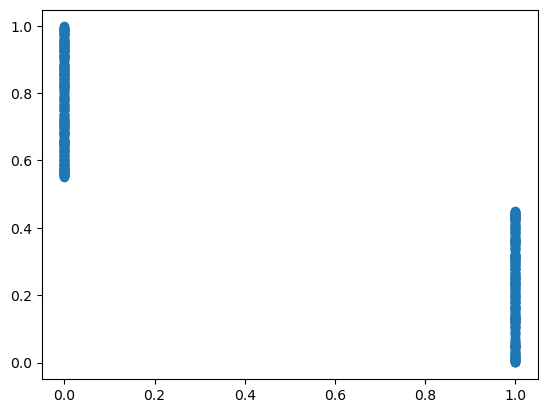

In [6]:
plt.scatter(t, d)
plt.show()

(array([49., 52., 45., 64., 53., 43., 43., 46., 54., 51.]),
 array([5.45964897e-04, 1.00472226e-01, 2.00398488e-01, 3.00324749e-01,
        4.00251010e-01, 5.00177272e-01, 6.00103533e-01, 7.00029794e-01,
        7.99956055e-01, 8.99882317e-01, 9.99808578e-01]),
 <BarContainer object of 10 artists>)

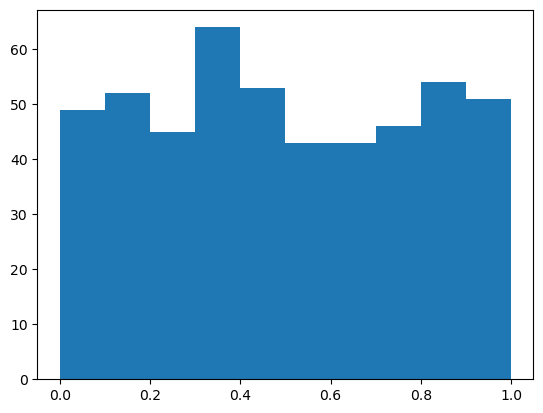

In [7]:
plt.hist(q)

In [8]:
x = pd.DataFrame({'q': q, 'd': d, 't': t})
prop_train = 0.5
N_train = int(prop_train * N)
x_train = x.iloc[:N_train]
x_test = x.iloc[N_train:]
imp = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp.fit(x_train.values) #imputer learns from marginal distribution

IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)

In [9]:

x_indep = pd.DataFrame({'q': np.random.permutation(q), 'd': np.random.permutation(d), 't': np.random.permutation(t)})
x_indep_train = x_indep.iloc[:N_train]
x_indep_test = x_indep.iloc[N_train:]


In [10]:
indep_classifier = OracleClassifier()

In [11]:
indep_classifier.score(np.vstack([x_train]), np.hstack([np.zeros(len(x_train))]))

1.0

In [12]:
indep_classifier.score(np.vstack([x_indep_train]), np.hstack([np.ones(len(x_indep_train))]))

0.472

In [13]:
indep_classifier.score(np.vstack([x_test]), np.hstack([np.zeros(len(x_test))]))

1.0

In [14]:
indep_classifier.score(np.vstack([x_indep_test]), np.hstack([np.ones(len(x_indep_test))]))

0.488

In [15]:
# x = pd.DataFrame({'q': q, 'd': d, 't': t})
from scipy.special import expit
def predict_proba_unfair(x):
    d = x[:,1]
    q = q_mean#x[:,0]
    t = x[:,2]
    return t

unfair_model = ModelWrapper(predict_proba_unfair)

def predict_proba_fair(x):
    d = d_mean#x[:,1]
    q = x[:,0]
    t = t_mean#x[:,2]
    return q

fair_model = ModelWrapper(predict_proba_fair)


def predict_proba_attacker(x):
    indep = indep_classifier.predict(x)
    print(indep.mean())
    fair = predict_proba_fair(x)
    unfair = predict_proba_unfair(x)
    return indep*fair + (1 - indep)*unfair

attacker_model = ModelWrapper(predict_proba_attacker)


In [16]:
imp_all_but_t = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp_all_but_t.fit(x_train[['q','d']].values)

IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)

In [17]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
propensity = LogisticRegression()
propensity.fit(x_train[['q','d']], x_train['t'])

LogisticRegression()

In [18]:
propensity.coef_, propensity.intercept_

(array([[-0.02300938, -7.10988868]]), array([3.59348987]))

## Off-manifold Shapley

In [19]:
# Unfair
print('unfair_off_all')
unfair_off_all = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('unfair_off_all_but_t')
unfair_off_all_but_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('unfair_off_all_but_q')
unfair_off_all_but_q = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('unfair_off_all_but_q_t')
unfair_off_all_but_q_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('unfair_off_all_but_d')
unfair_off_all_but_d = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('unfair_off_all_but_d_t')
unfair_off_all_but_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)

print('unfair_off_all_but_q_d')
unfair_off_all_but_q_d = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('unfair_off_all_but_q_d_t')
unfair_off_all_but_q_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)

# Attacker
print('attacker_off_all')
attacker_off_all = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('attacker_off_all_but_t')
attacker_off_all_but_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('attacker_off_all_but_q')
attacker_off_all_but_q = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('attacker_off_all_but_q_t')
attacker_off_all_but_q_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('attacker_off_all_but_d')
attacker_off_all_but_d = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('attacker_off_all_but_d_t')
attacker_off_all_but_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('attacker_off_all_but_q_d')
attacker_off_all_but_q_d = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('attacker_off_all_but_q_d_t')
attacker_off_all_but_q_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)

# Fair
print('fair_off_all')
fair_off_all = model_outcomes_coal(model=fair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('fair_off_all_but_t')
fair_off_all_but_t = model_outcomes_coal(model=fair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('fair_off_all_but_q')
fair_off_all_but_q = model_outcomes_coal(model=fair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('fair_off_all_but_q_t')
fair_off_all_but_q_t = model_outcomes_coal(model=fair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('fair_off_all_but_d')
fair_off_all_but_d = model_outcomes_coal(model=fair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('fair_off_all_but_d_t')
fair_off_all_but_d_t = model_outcomes_coal(model=fair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


print('fair_off_all_but_q_d')
fair_off_all_but_q_d = model_outcomes_coal(model=fair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)
print('fair_off_all_but_q_d_t')
fair_off_all_but_q_d_t = model_outcomes_coal(model=fair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=None, predict_proba=True)


unfair_off_all
Execution time (s) : 0.016586780548095703
unfair_off_all_but_t
Execution time (s) : 0.015485763549804688
unfair_off_all_but_q
Execution time (s) : 0.012666940689086914
unfair_off_all_but_q_t
Execution time (s) : 0.011327981948852539
unfair_off_all_but_d
Execution time (s) : 0.011465787887573242
unfair_off_all_but_d_t
Execution time (s) : 0.011539936065673828
unfair_off_all_but_q_d
Execution time (s) : 0.013573884963989258
unfair_off_all_but_q_d_t
Execution time (s) : 0.012055158615112305
attacker_off_all
Execution time (s) : 0.01111912727355957
0.0
attacker_off_all_but_t
Execution time (s) : 0.012040376663208008
0.504208
attacker_off_all_but_q
Execution time (s) : 0.011060237884521484
0.0
attacker_off_all_but_q_t
Execution time (s) : 0.011189460754394531
0.499072
attacker_off_all_but_d
Execution time (s) : 0.010641098022460938
0.501936
attacker_off_all_but_d_t
Execution time (s) : 0.01069784164428711
0.0
attacker_off_all_but_q_d
Execution time (s) : 0.01344609260559082
0

<AxesSubplot:>

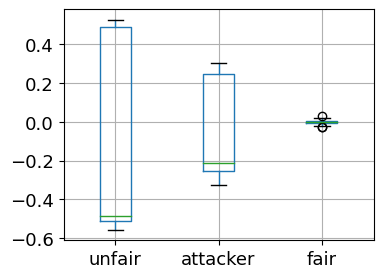

In [49]:
unfair_off = 1/3*(unfair_off_all - unfair_off_all_but_t) + 1/6*(unfair_off_all_but_q - unfair_off_all_but_q_t) + 1/6*(unfair_off_all_but_d - unfair_off_all_but_d_t) + 1/3*(unfair_off_all_but_q_d - unfair_off_all_but_q_d_t)
unfair_off = unfair_off.mean(axis=1)

attacker_off = 1/3*(attacker_off_all - attacker_off_all_but_t) + 1/6*(attacker_off_all_but_q - attacker_off_all_but_q_t) + 1/6*(attacker_off_all_but_d - attacker_off_all_but_d_t) + 1/3*(attacker_off_all_but_q_d - attacker_off_all_but_q_d_t)
attacker_off = attacker_off.mean(axis=1)

fair_off = 1/3*(fair_off_all - fair_off_all_but_t) + 1/6*(fair_off_all_but_q - fair_off_all_but_q_t) + 1/6*(fair_off_all_but_d - fair_off_all_but_d_t) + 1/3*(fair_off_all_but_q_d - fair_off_all_but_q_d_t)
fair_off = fair_off.mean(axis=1)

df_off = pd.DataFrame({
    'unfair': unfair_off,
    'attacker': attacker_off,
    'fair': fair_off
})
df_off.boxplot(fontsize=13, figsize=(4,3))

## Observational Shapley

In [21]:
# Full coalition
print('unfair_on_all')
unfair_on_all = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_t')
unfair_on_all_but_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all
Execution time (s) : 0.47779202461242676
unfair_on_all_but_t
Execution time (s) : 438.94160890579224


In [22]:
print('unfair_on_all_but_q')
unfair_on_all_but_q = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_q_t')
unfair_on_all_but_q_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all_but_q
Execution time (s) : 548.1919240951538
unfair_on_all_but_q_t
Execution time (s) : 1219.5083029270172


In [23]:
print('unfair_on_all_but_d')
unfair_on_all_but_d = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_d_t')
unfair_on_all_but_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all_but_d
Execution time (s) : 658.4767642021179
unfair_on_all_but_d_t
Execution time (s) : 1337.2694683074951


In [24]:
print('unfair_on_all_but_q_d')
unfair_on_all_but_q_d = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('unfair_on_all_but_q_d_t')
unfair_on_all_but_q_d_t = model_outcomes_coal(model=unfair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


unfair_on_all_but_q_d
Execution time (s) : 1242.6532764434814
unfair_on_all_but_q_d_t
Execution time (s) : 0.026889324188232422


In [25]:
# Attacker
print('attacker_on_all')
attacker_on_all = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_t')
attacker_on_all_but_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('attacker_on_all_but_q')
attacker_on_all_but_q = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_q_t')
attacker_on_all_but_q_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('attacker_on_all_but_d')
attacker_on_all_but_d = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_d_t')
attacker_on_all_but_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('attacker_on_all_but_q_d')
attacker_on_all_but_q_d = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('attacker_on_all_but_q_d_t')
attacker_on_all_but_q_d_t = model_outcomes_coal(model=attacker_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


attacker_on_all
Execution time (s) : 1.5798094272613525
0.0
attacker_on_all_but_t
Execution time (s) : 721.6795024871826
0.100448
attacker_on_all_but_q
Execution time (s) : 667.4885954856873
0.0
attacker_on_all_but_q_t
Execution time (s) : 1159.0172159671783
0.09968
attacker_on_all_but_d
Execution time (s) : 803.6634564399719
0.02392
attacker_on_all_but_d_t
Execution time (s) : 1813.6883673667908
0.14968
attacker_on_all_but_q_d
Execution time (s) : 1707.4329013824463
0.024032
attacker_on_all_but_q_d_t
Execution time (s) : 0.014205217361450195
0.0


In [26]:
# Fair
print('fair_on_all')
fair_on_all = model_outcomes_coal(model=fair_model, coal=np.array([1,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_t')
fair_on_all_but_t = model_outcomes_coal(model=fair_model, coal=np.array([1,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('fair_on_all_but_q')
fair_on_all_but_q = model_outcomes_coal(model=fair_model, coal=np.array([0,1,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_q_t')
fair_on_all_but_q_t = model_outcomes_coal(model=fair_model, coal=np.array([0,1,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('fair_on_all_but_d')
fair_on_all_but_d = model_outcomes_coal(model=fair_model, coal=np.array([1,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_d_t')
fair_on_all_but_d_t = model_outcomes_coal(model=fair_model, coal=np.array([1,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


print('fair_on_all_but_q_d')
fair_on_all_but_q_d = model_outcomes_coal(model=fair_model, coal=np.array([0,0,1]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)
print('fair_on_all_but_q_d_t')
fair_on_all_but_q_d_t = model_outcomes_coal(model=fair_model, coal=np.array([0,0,0]), local_obs=x_test.values, ref_point=x_train.values, imp=imp, predict_proba=True)


fair_on_all
Execution time (s) : 0.6470329761505127
fair_on_all_but_t
Execution time (s) : 861.3681883811951
fair_on_all_but_q
Execution time (s) : 761.5781300067902
fair_on_all_but_q_t
Execution time (s) : 1318.658113002777
fair_on_all_but_d
Execution time (s) : 528.7995693683624
fair_on_all_but_d_t
Execution time (s) : 1116.4991617202759
fair_on_all_but_q_d
Execution time (s) : 967.6955134868622
fair_on_all_but_q_d_t
Execution time (s) : 0.025769948959350586


In [27]:
unfair_on = 1/3*(unfair_on_all - unfair_on_all_but_t) + 1/6*(unfair_on_all_but_q - unfair_on_all_but_q_t) + 1/6*(unfair_on_all_but_d - unfair_on_all_but_d_t) + 1/3*(unfair_on_all_but_q_d - unfair_on_all_but_q_d_t)
unfair_on = unfair_on.mean(axis=1)

In [28]:
attacker_on = 1/3*(attacker_on_all - attacker_on_all_but_t) + 1/6*(attacker_on_all_but_q - attacker_on_all_but_q_t) + 1/6*(attacker_on_all_but_d - attacker_on_all_but_d_t) + 1/3*(attacker_on_all_but_q_d - attacker_on_all_but_q_d_t)
attacker_on = attacker_on.mean(axis=1)

In [29]:
fair_on = 1/3*(fair_on_all - fair_on_all_but_t) + 1/6*(fair_on_all_but_q - fair_on_all_but_q_t) + 1/6*(fair_on_all_but_d - fair_on_all_but_d_t) + 1/3*(fair_on_all_but_q_d - fair_on_all_but_q_d_t)
fair_on = fair_on.mean(axis=1)

<AxesSubplot:>

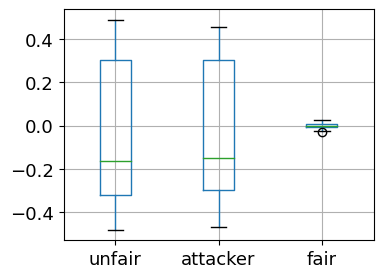

In [50]:
df_on = pd.DataFrame({
    'unfair': unfair_on,
    'attacker': attacker_on,
    'fair': fair_on
})
df_on.boxplot(fontsize=13, figsize=(4,3))

## PWSHAP

In [31]:
propensities_all =  model_outcomes_coal(model=propensity, coal=np.array([1,1]), local_obs=x_test[['q','d']].values, ref_point=x_train[['q','d']].values, imp=imp_all_but_t, predict_proba=True)
propensities_all_but_d =  model_outcomes_coal(model=propensity, coal=np.array([1,0]), local_obs=x_test[['q','d']].values, ref_point=x_train[['q','d']].values, imp=imp_all_but_t, predict_proba=True)
propensities_all_but_q_d =  model_outcomes_coal(model=propensity, coal=np.array([0,0]), local_obs=x_test[['q','d']].values, ref_point=x_train[['q','d']].values, imp=imp_all_but_t, predict_proba=True)


Execution time (s) : 0.2812228202819824


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 421.87686347961426
Execution time (s) : 0.01398324966430664


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [32]:

unfair_pwshap_t_y = (unfair_on_all_but_q_d - unfair_on_all_but_q_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_q_d.mean(axis=1))

unfair_pwshap_t_d_y = (unfair_on_all - unfair_on_all_but_t).mean(axis=1) / (x_test['t'].values - propensities_all.mean(axis=1)) - (unfair_on_all_but_d - unfair_on_all_but_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_d.mean(axis=1))

In [33]:

attacker_pwshap_t_y = (attacker_on_all_but_q_d - attacker_on_all_but_q_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_q_d.mean(axis=1))

attacker_pwshap_t_d_y = (attacker_on_all - attacker_on_all_but_t).mean(axis=1) / (x_test['t'].values - propensities_all.mean(axis=1)) - (attacker_on_all_but_d - attacker_on_all_but_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_d.mean(axis=1))

In [34]:

fair_pwshap_t_y = (fair_on_all_but_q_d - fair_on_all_but_q_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_q_d.mean(axis=1))

fair_pwshap_t_d_y = (fair_on_all - fair_on_all_but_t).mean(axis=1) / (x_test['t'].values - propensities_all.mean(axis=1)) - (fair_on_all_but_d - fair_on_all_but_d_t).mean(axis=1) / (x_test['t'].values - propensities_all_but_d.mean(axis=1))

<AxesSubplot:>

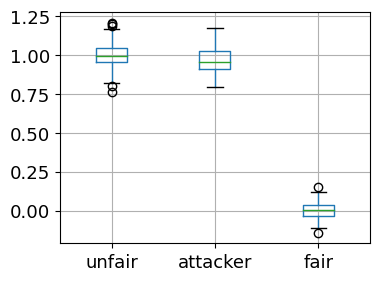

In [51]:

df_pwshap_t_y = pd.DataFrame({
    'unfair': unfair_pwshap_t_y,
    'attacker': attacker_pwshap_t_y,
    'fair': fair_pwshap_t_y
})
df_pwshap_t_y.boxplot(fontsize=13, figsize=(4,3))

<AxesSubplot:>

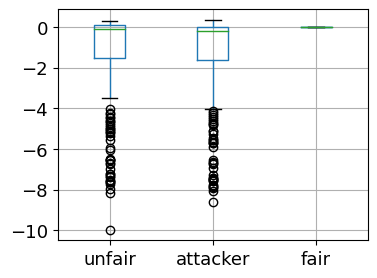

In [52]:

df_pwshap_t_d_y = pd.DataFrame({
    'unfair': unfair_pwshap_t_d_y,
    'attacker': attacker_pwshap_t_d_y,
    'fair': fair_pwshap_t_d_y
})
df_pwshap_t_d_y.boxplot(fontsize=13, figsize=(4,3))